In [1]:
%matplotlib inline
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
import json
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from qutip import *


def coherent_state(n, alpha):
    return exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

# Cavity Drive

In [2]:
xis = []

In [3]:
expt_name = 'sequential_photon_number_distribution_measurement'

filelist = np.arange(1979,2003)  # 11/20/22


titles = ['qubit in g']
shows = ['I']

import math
import scipy.special
from scipy.optimize import curve_fit

scs = []
amps = []
for ii,i in enumerate(filelist):
    filename = "230104_transfer_data//" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['photon_number_distribution_measurement']
        print ("cavity pulse type", expt_cfg['cavity_pulse_type'], expt_cfg['mode_index'])
        nu_c = quantum_device_cfg['flux_pulse_info']['1']['cavity_freqs'][expt_cfg['mode_index']]
        chis = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        I,Q = array(a['I']),array(a['Q'])
        cav_lens = arange(swp_cfg['start_len'],swp_cfg['stop_len'],swp_cfg['len_step'])
        fit_alphas = []
        print(cav_lens)
        amps.append(expt_cfg['prep_cav_amp'])
        f = arange(expt_cfg['N_max'])
        fig = plt.figure(figsize=(14,3*len(I)))
        for kk,k in enumerate(I):
            popt, pcov = curve_fit(coherent_state, f, k)
            print(popt)
            fit_alphas.append(popt[0])
            if ii == len(filelist) - 1:
                ax=fig.add_subplot(len(I),4,kk+1)
                ax.plot(f,k,'ko--')
                ax.plot(f, coherent_state(f, popt), 'r--', linewidth=3)

                ax.set_xlabel('Photon Number')
                plt.tight_layout()
        cav_lens = cav_lens[:len(fit_alphas)]
        ax = fig.add_subplot(len(I),2,len(I)/2+1)
#         amps = amps[1:-4]
#         fit_alphas = fit_alphas[1:-4]
        ax.plot(cav_lens, fit_alphas,'bo',markersize = 7.5)
        popt, pcov = curve_fit(line, cav_lens, fit_alphas)
        print("linear fit: ", popt)
        ax.plot(cav_lens, line(cav_lens, *popt))

        popt, pcov = curve_fit(proportional, cav_lens, fit_alphas)
        print("proportional fit: ", popt)
        ax.plot(cav_lens, proportional(cav_lens, popt))
        ax.set_xlabel("prep cav len (ns)")
        ax.set_ylabel("alpha")
        scs.append(popt[0])

        
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
print(amps)
popt, pcov = curve_fit(proportional, amps,scs)
print("Converstion from xi to a = ", popt[0],"GHz")

xis.append(popt[0])

ax.plot(amps, proportional(amps, popt),label  = '$\\xi = $'+str(around(popt[0],6))+' a (GHz)')
popt, pcov = curve_fit(line, amps,scs)
print("linear fit: ", popt)
ax.loglog(amps[:-1],scs[:-1],'bo',markersize = 10)
ax.loglog(amps[-1],scs[-1],'ro',markersize = 10)
ax.axvline(2/256)
ax.axvline(4/256)
ax.axvline(6/256)
#ax.axvline(0.022, color='r')
ax.legend()
ax.set_ylabel('Scale ($\\alpha$ / prep cav len)')
ax.set_xlabel('amplitude')

OSError: Unable to open file (unable to open file: name = '230104_transfer_data//01979_sequential_photon_number_distribution_measurement.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
from scipy import interpolate
transfer_fn = interpolate.interp1d(scs, amps)
scs_gauss = scs
amps_gauss = amps
# test_omega = np.arange(4e-3, 5e-3, 1e-6)
test_omega = np.arange(4e-4, 5e-4, 1e-7)
fig = plt.figure(figsize=(12,5))
axvline(1.3/8)
plt.plot(test_omega, transfer_fn(test_omega),'b-')
plt.loglog(scs,amps, 'ro',alpha=0.5)
plt.xlabel("scale (alpha / prep cav len)")
plt.ylabel("amplitude")

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

# Qubit Drive

In [12]:
import cmath
from scipy import optimize 


def decaysin(p,x):
    """p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    return p[0]*np.sin(2.*np.pi*p[1]*x+p[2]*np.pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]

def fitdecaysin(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        FFT=scipy.fft(fitdatay)
        fft_freqs=scipy.fftpack.fftfreq(len(fitdatay),fitdatax[1]-fitdatax[0])
        max_ind=np.argmax(abs(FFT[4:int(len(fitdatay)/2)]))+4
        fft_val=FFT[max_ind]
        
        fitparams=[0,0,0,0,0]
        fitparams[4]=np.mean(fitdatay)
        fitparams[0]=(max(fitdatay)-min(fitdatay))/2.#2*abs(fft_val)/len(fitdatay)
        fitparams[1]=fft_freqs[max_ind]
        fitparams[2]=(cmath.phase(fft_val)-np.pi/2.)*180./np.pi
        fitparams[3]=(max(fitdatax)-min(fitdatax))

        #fitparams[5]=fitdatax[0]
        
    decaysin3 = lambda p, x: p[0] * np.sin(2. * np.pi * p[1] * x + p[2] * np.pi / 180.) * np.e ** (
    -1. * (x - fitdatax[0]) / p[3]) + p[4]
    # decaysin3 = lambda p, x: p[0] * np.sin(2. * np.pi * p[1] * x + p[2] - np.pi / 2.) * np.e ** (
    # -1. * (x - fitdatax[0]) / p[3]) + p[4]
    #print "fitparams: ",fitparams
    p1 = fitgeneral(fitdatax, fitdatay, decaysin3, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1  


def fitgeneral(xdata, ydata, fitfunc, fitparams, domain=None, showfit=False, showstartfit=False, showdata=True,
               label="", mark_data='bo', mark_fit='r-'):
    """Uses optimize.leastsq to fit xdata ,ydata using fitfunc and adjusting fit params"""

    # sort data
    order = np.argsort(xdata)
    xdata = xdata[order]
    ydata = ydata[order]

    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
#    print 'minimum', np.min(fitdatay)
#    ymin=np.min(fitdatay)
    errfunc = lambda p, x, y: (fitfunc(p,x) - y) #there shouldn't be **2 # Distance to the target function
    startparams=fitparams # Initial guess for the parameters
    bestfitparams, success = optimize.leastsq(errfunc, startparams[:], args=(fitdatax,fitdatay))
    if showfit:
        if showdata:
            plt.plot(fitdatax,fitdatay,mark_data,label=label+" data")
        if showstartfit:
            plt.plot(fitdatax,fitfunc(startparams,fitdatax),label=label+" startfit")
        plt.plot(fitdatax,fitfunc(bestfitparams,fitdatax),mark_fit,label=label+" fit")
        if label!='': plt.legend()
        err=math.fsum(errfunc(bestfitparams,fitdatax,fitdatay))
        #print 'the best fit has an RMS of {0}'.format(err)
#    plt.t
#    plt.figtext()    
    return bestfitparams
    

square
0.03248505794537599
0.03725666598760919
0.04194816062597905
0.045673986039951174
0.04865539746850875
0.050856719178525946
{'amp': 0.9999999999999999, 'stop': 90, 'step': 1, 'pi_calibration': True, 'start': 0, 'acquisition_num': 1000, 'on_qubits': ['1'], 'singleshot': False, 'pulse_type': 'square'}
linear fit:  [0.03708009 0.01500259]
proportional fit:  [0.05609747]
linear fit:  [0.11649055 0.04713204]
proportional fit:  [0.17623539]


C:\Users\hek\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


square
0.006983356600536274
0.010518136227883277
0.014170155517943813
0.017728486214784615
0.020673752441037696
0.02401443960611881
0.02747788636261399
0.030376553766763743
{'amp': 0.45000000000000007, 'stop': 450, 'step': 5, 'pi_calibration': True, 'start': 0, 'acquisition_num': 1000, 'on_qubits': ['1'], 'singleshot': False, 'pulse_type': 'square'}
linear fit:  [0.06691173 0.00059212]
proportional fit:  [0.06874647]
linear fit:  [0.21020939 0.0018602 ]
proportional fit:  [0.2159734]
square
0.0023380521610874313
0.0027100676296216235
0.0031752408759962757
0.0034668724956730262
0.0039661830055088545
0.0043773645825301456
0.0046646230152886355
0.005133653293953686
0.005536640110186507
0.005911519641826868
0.006378971304943499
0.006763774390175488
{'amp': 0.09499999999999997, 'stop': 1000, 'step': 10, 'pi_calibration': True, 'start': 0, 'acquisition_num': 1000, 'on_qubits': ['1'], 'singleshot': False, 'pulse_type': 'square'}
linear fit:  [ 0.08041646 -0.00089286]
proportional fit:  [0.068

linear fit:  [ 0.06819742 -0.00053694]
proportional fit:  [0.04164554]
linear fit:  [ 0.2142485  -0.00168684]
proportional fit:  [0.13083334]
[0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 0.1, 0.15000000000000002, 0.20000000000000004, 0.25000000000000006, 0.30000000000000004, 0.3500000000000001, 0.40000000000000013, 0.45000000000000007, 0.04, 0.045, 0.049999999999999996, 0.05499999999999999, 0.05999999999999999, 0.06499999999999999, 0.06999999999999998, 0.07499999999999998, 0.07999999999999999, 0.08499999999999998, 0.08999999999999997, 0.09499999999999997, 0.01, 0.015, 0.019999999999999997, 0.024999999999999998, 0.03, 0.034999999999999996, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.02, 0.022, 0.024, 0.026000000000000002, 0.028]


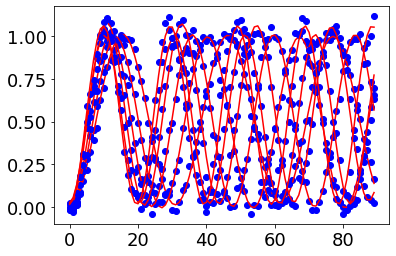

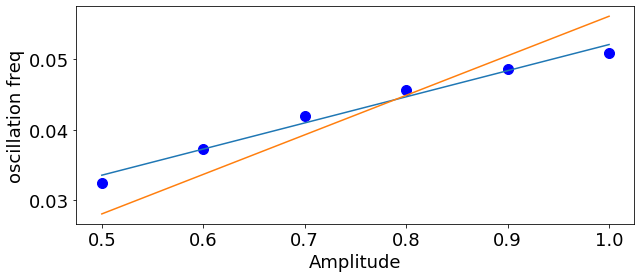

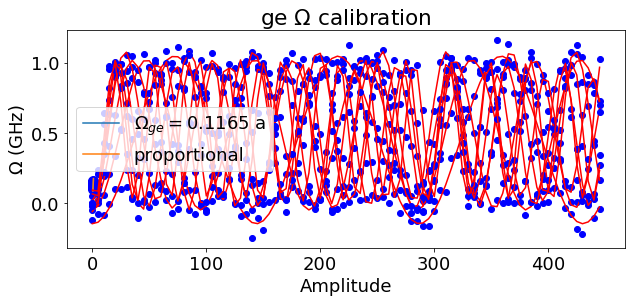

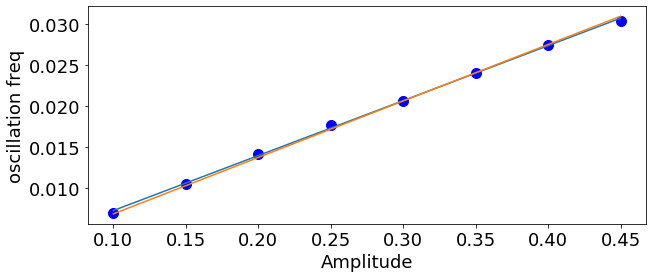

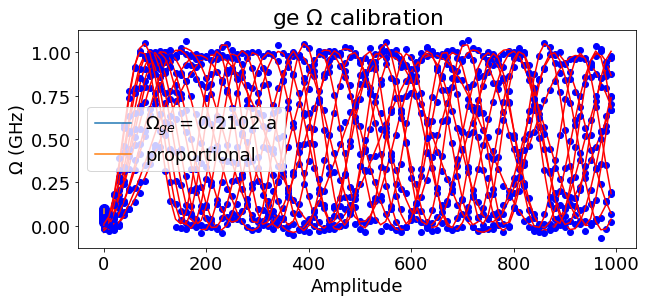

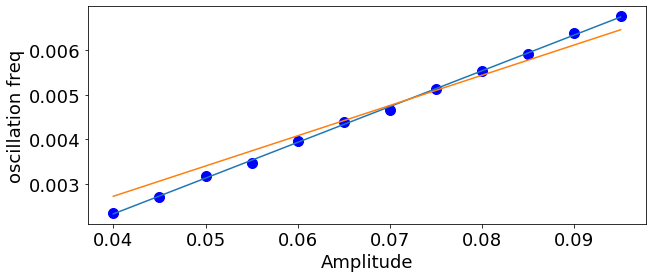

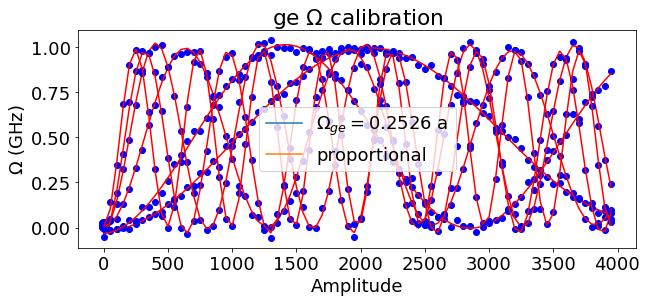

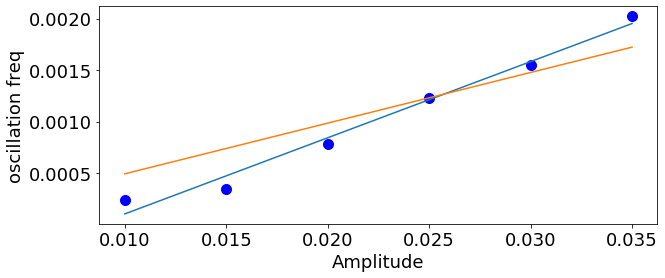

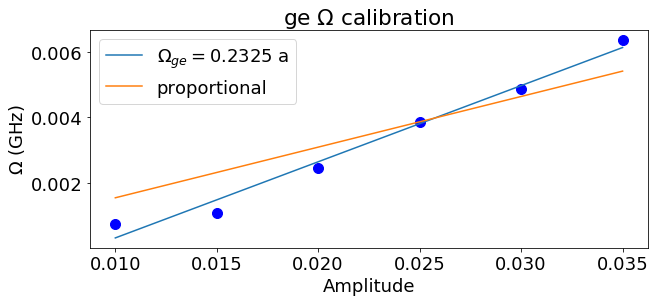

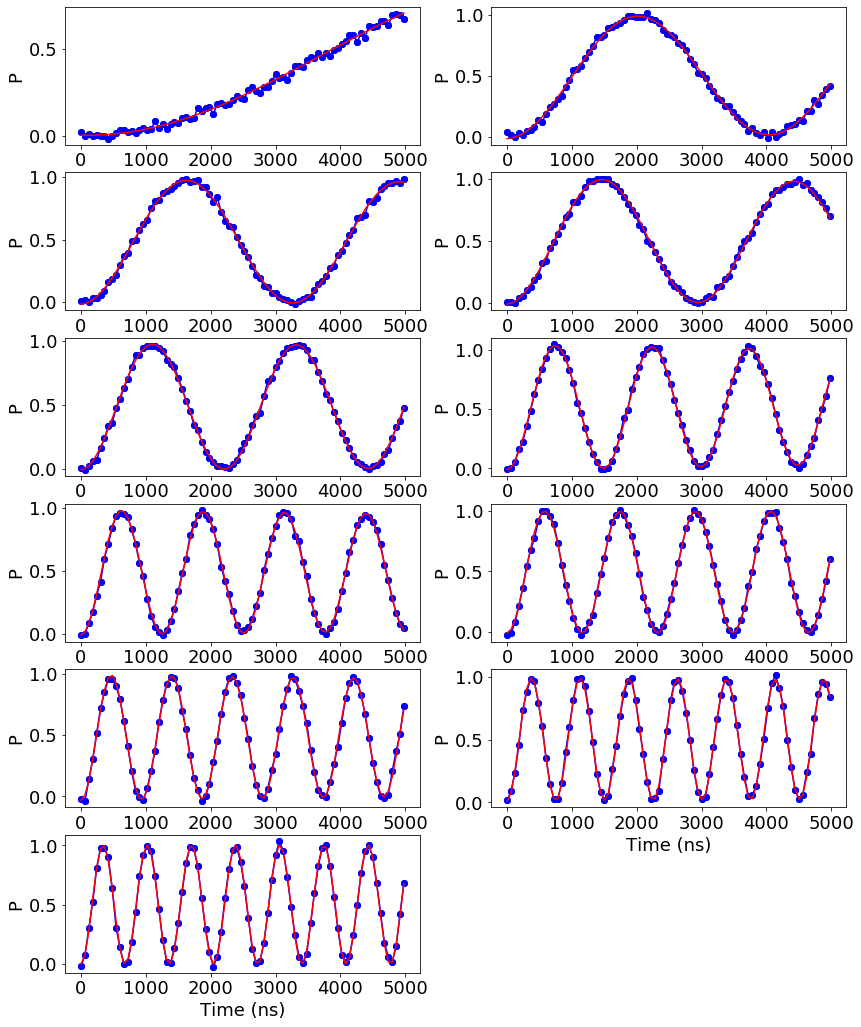

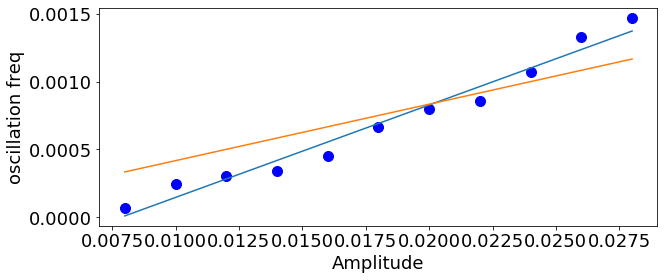

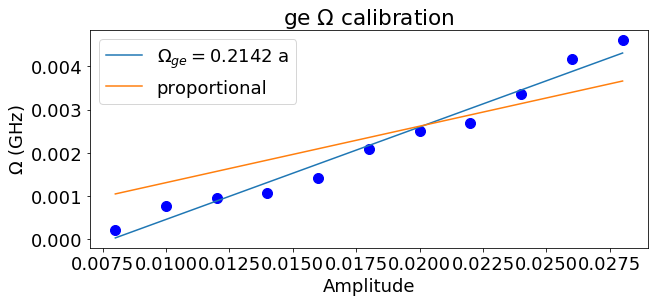

In [13]:
expt_name = 'sequential_rabi_amp_sweep'
filelist = [24,25,26,27,28]

shows = 'I'

import math
import scipy.special

ampslist = []
omegaslist = []
# skiplist = [[0], [1,4], [], [], [0,1], [0,4,5], [1]]
skiplist = [[], [], [], [], [], [], []]
skiplist2 = [[], [0], [], [], [4], [], [], [], []]


for kk,filenum in enumerate(filelist):
    rabi_freqs = []
    filename = "230105_transfer_data" + str(filenum).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))['sequential_rabi_amp_sweep'.lower()]
        if swp_cfg['calibrate_weak_drive']:
            expt_cfg = (json.loads(a.attrs['experiment_cfg']))['weak_rabi']
        else:
            expt_cfg = (json.loads(a.attrs['experiment_cfg']))['rabi']
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        amps = arange(swp_cfg['start'],swp_cfg['stop'],swp_cfg['step'])
        P = array(a['I']) 
        amps = amps[:len(P)]
        dt = 0.0625
        print(expt_cfg['pulse_type'])
        t = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])
        
        if kk == len(filelist) - 1:
            fig = plt.figure(figsize=(14,3*len(P)))
        for ii,y in enumerate(P):
            if kk == len(filelist) - 1:
                ax=fig.add_subplot(len(P),2,ii+1)
                ax.plot(t,y,'bo-')
                ax.set_xlabel('Time (ns)')
                ax.set_ylabel('P')
#                 t_pi = 1/(2*abs(p[1]))
#                 t_half_pi = 1/(4*abs(p[1]))
                   
                #ax.axvline(t_pi,color='k',linestyle='dashed')
                #ax.axvline(t_half_pi,color='k',linestyle='dashed')
#             p = fitdecaysin(t[2:-1],y[2:-1],showfit=False)
            
            if ii in skiplist2[kk]:
                p = fitdecaysin(t[6:-6],y[6:-6],showfit=False)
            elif (filenum == 14 and ii in [0,1]):
                print("catch")
                p = fitdecaysin(t[2:-4],y[2:-4],showfit=False)
            elif (filenum == 17 and ii in [0]):
                p = fitdecaysin(t[4:-8],y[4:-8],showfit=True)
            elif filenum == 4 or filenum == 17:
                print("pass")
                p = fitdecaysin(t[6:-3],y[6:-3], showfit=False)
            else:
                p = fitdecaysin(t[2:-1],y[2:-1],showfit=False)
            if not (filenum == 17 and ii == 0):
                p = fitdecaysin(t,y,fitparams=p, showfit=True)
            # ax.set_ylim(0,1)
            rabi_freqs.append(abs(p[1]))
            print(p[1])
        #print("rabi freqs:", rabi_freqs)
        #print("amps:", amps)

#             print("Half pi length =",t_half_pi,"ns")
#             print("pi length =",t_pi,"ns")
#             print ("Rabi decay time = ", p[3],"ns")
        print(expt_cfg)
        fig = plt.figure(figsize = (10,4))
        ax = fig.add_subplot(1,1,1)
        ax.plot(amps, rabi_freqs,'bo',markersize = 10)
        popt, pcov = curve_fit(line, amps, rabi_freqs)
        print("linear fit: ", popt)
        ax.plot(amps, line(amps, *popt))
        popt, pcov = curve_fit(proportional, amps, rabi_freqs)
        print("proportional fit: ", popt)
        ax.plot(amps, proportional(amps, popt))
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("oscillation freq")
        omegas = np.pi*array(rabi_freqs)
        fig = plt.figure(figsize = (10,4))
        ax = fig.add_subplot(1,1,1,title = 'ge $\\Omega$ calibration')
        ax.plot(amps, omegas,'bo',markersize = 10)
        ampslist.extend(list(np.delete(amps, skiplist[kk])))
        omegaslist.extend(np.delete(omegas, skiplist[kk]))
        popt, pcov = curve_fit(line, amps, omegas)
        print("linear fit: ", popt)
        ax.plot(amps, line(amps, *popt),label  = '$\\Omega_{ge} = $'+str(around(popt[0],4))+' a')
        popt, pcov = curve_fit(proportional, amps, omegas)
        print("proportional fit: ", popt)
        ax.plot(amps, proportional(amps, popt), label='proportional')
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("$\\Omega$ (GHz)")
        ax.legend()
        
print(ampslist)

proportional fit:  [0.18320197]
[0.18320197]
[5.45845661]


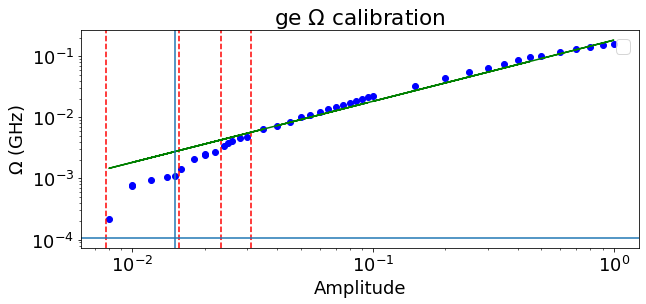

In [14]:
o = array(omegaslist).flatten().flatten()
a = array(ampslist).flatten().flatten()
# o = np.append(o, 0.0)
# a = np.append(a, 0.0)

fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1,1,1,title = 'ge $\\Omega$ calibration')

loglog(a,o,'bo')
popt, pcov = curve_fit(line, a, o)
# print("linear fit: ", popt)
# ax.plot(a, line(a, *popt),label  = '$\\Omega_{ge} = $'+str(around(popt[0],4))+' a')
popt, pcov = curve_fit(proportional, a, o)
for ii in range(4):
    ax.axvline((2*ii+2)/256,color='r',linestyle='dashed')
    
print("proportional fit: ", popt)
ax.plot(a, proportional(a, popt),color='g')
print(popt)
print(1/array(popt))
ax.set_xlabel("Amplitude")
ax.set_ylabel("$\\Omega$ (GHz)")
ax.legend()
ax.axvline(0.015)
ax.axhline(0.107e-3)
# ax.axvline(0.1, color='k')